## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,\
    cross_val_score
from sklearn.metrics import SCORERS
# from imblearn.under_sampling import TomekLinks
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from code.functions import *
# %matplotlib inline

# EDA

## Load Data

In [2]:
pd.set_option('display.max_columns',None)

In [3]:
df = pd.read_csv('data/cmc.data', names = ['age','edu','hus_edu','chil','rel','work',
                                        'hus_ocu','sol','media','cmc'])

In [4]:
df.hus_ocu.value_counts()

3    585
1    436
2    425
4     27
Name: hus_ocu, dtype: int64

## Feature Engineering

49 0.16295261509293898


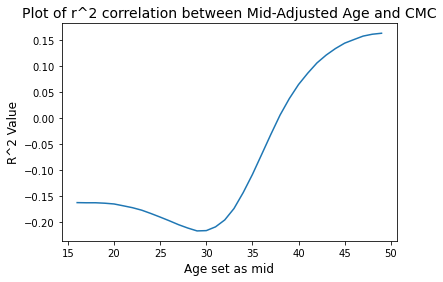

In [5]:
df_age = df.copy()
r_values = {}
ages = range(df_age.age.min(), df_age.age.max() + 1)
for age in ages:
    df_age['age_mid'] = np.abs(df_age['age'] - age)
    r_values[age] = df_age['age_mid'].corr(df_age.cmc)
fig, ax = plt.subplots()
ax.plot(*zip(*sorted(r_values.items())))
ax.set_title('Plot of r^2 correlation between Mid-Adjusted Age and CMC', fontdict = {'fontsize': 14})
ax.set_xlabel('Age set as mid', fontdict = {'fontsize': 12})
ax.set_ylabel('R^2 Value', fontdict = {'fontsize': 12})
print(max(r_values, key=r_values.get), max(r_values.values()))

0 0.08277224205909448


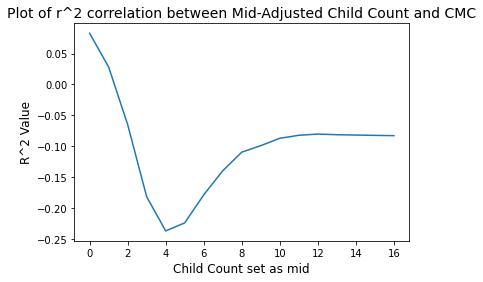

In [6]:
df_child = df.copy()
r_values = {}
childs = range(df_child.chil.min(), df_child.chil.max() + 1)
for child in childs:
    df_child['chil_mid'] = np.abs(df_child.chil - child)
    r_values[child] = df_child['chil_mid'].corr(df_child.cmc)
fig, ax = plt.subplots()
ax.plot(*zip(*sorted(r_values.items())))
ax.set_title('Plot of r^2 correlation between Mid-Adjusted Child Count and CMC', fontdict = {'fontsize': 14})
ax.set_xlabel('Child Count set as mid', fontdict = {'fontsize': 12})
ax.set_ylabel('R^2 Value', fontdict = {'fontsize': 12})
print(max(r_values, key=r_values.get), max(r_values.values()))

## Dummying, Scaling/Fit/Transform

In [7]:
X = df.copy()
y = X.pop('cmc')
to_dummy = ['edu', 'hus_edu', 'chil', 'hus_ocu', 'sol']
X_with_dums = pd.get_dummies(X, columns=to_dummy, drop_first=True)
# X_with_dums.shape
X_train_df, X_test, y_train, y_test = train_test_split(
    X_with_dums, y, test_size=.25,
    random_state=1)
# X_train.shape
rs = RobustScaler()
rs.fit(X_train_df)
X_train = rs.transform(X_train_df)
X_test = rs.transform(X_test)

# Modeling

## Logistic Regression w/ Children dummied

{'lr__C': 29.763514416313132, 'lr__class_weight': 'balanced', 'lr__dual': True, 'lr__l1_ratio': 0.0001, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Classifier  LogisticRegression
Num features:  30
Model score:  0.5691056910569106
Accuracy score:  0.5691056910569106
Model F1 (micro):  0.5691056910569106
Model F1 (macro):  0.5574927347077924
Model F1 (weighted):  0.5764263245764513
Cross validation score:  [0.59459459 0.52702703 0.55405405 0.58108108 0.50684932]
Classification Report:
              precision    recall  f1-score   support

           1       0.74      0.60      0.66       161
           2       0.42      0.54      0.47        87
           3       0.53      0.55      0.54       121

    accuracy                           0.57       369
   macro avg       0.56      0.56      0.56       369
weighted avg       0.59      0.57      0.58       369

One-vs-One ROC AUC scores:
0.755270 (macro),
0.758523 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.760261 (macro),
0.

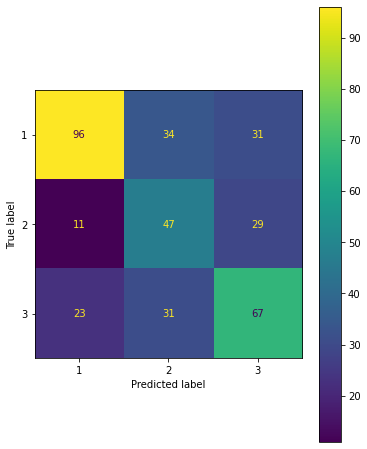

In [8]:
# set up pipeline
pipe_lr = Pipeline([('lr' , LogisticRegression(random_state=1, max_iter=200))])

params_grid_lr = {'lr__penalty' : ['l2','elasticnet'],
                  'lr__class_weight' : ['balanced'],
                  'lr__dual' : [True],
                  'lr__solver' : ['liblinear'],
                  'lr__C' : np.logspace(-4, 4, 20),
                  'lr__l1_ratio' : np.logspace(-4, 4, 20) # only needed for elasticnet
                 }

lr_clf = GridSearchCV(pipe_lr, param_grid = params_grid_lr, cv = 5, verbose=0, n_jobs=-1)

# fit on data
lr_clf.fit(X_train, y_train)
print(lr_clf.best_params_)
best_lr_clf = lr_clf.best_estimator_
model_stats(X_train_df.columns, best_lr_clf, 'LogisticRegression', X_test, y_test)

In [9]:
lr_clf_ = best_lr_clf.named_steps['lr']

In [10]:
coef_df = pd.DataFrame(lr_clf_.coef_, columns = X_with_dums.columns, index = [1,2,3])

In [11]:
coef_df

,age,rel,work,media,edu_2,edu_3,edu_4,hus_edu_2,hus_edu_3,hus_edu_4,chil_1,chil_2,chil_3,chil_4,chil_5,chil_6,chil_7,chil_8,chil_9,chil_10,chil_11,chil_12,chil_13,chil_16,hus_ocu_2,hus_ocu_3,hus_ocu_4,sol_2,sol_3,sol_4
1,1.211848,0.475184,0.053331,0.554059,-0.180346,-0.717574,-1.464151,-0.061563,-0.135813,0.085946,-3.202009,-3.954873,-4.917228,-5.124644,-5.187470,-5.278254,-5.283553,-4.718678,-6.247641,-4.163214,-5.317732,0.241475,-7.091968,0.0,0.189920,0.037743,-0.698276,-0.568309,-0.857986,-0.992111
2,-0.084644,-0.535873,-0.130645,-0.295243,0.990984,1.668855,2.169630,-1.593829,-1.787358,-1.555884,2.600917,2.661731,3.024892,3.456527,3.289442,3.552906,4.087073,3.356365,3.763410,3.338419,2.354828,-0.201738,4.448538,0.0,-0.662725,-0.540126,0.139895,0.437111,0.760551,0.878364
3,-1.250622,-0.051527,0.105381,-0.398501,-0.244203,-0.124125,0.148224,1.625599,1.760639,1.465486,2.413006,3.156048,3.779160,3.700157,3.959548,3.875160,3.447436,3.368838,4.773522,-0.653460,4.713334,-0.497728,4.872005,0.0,0.352998,0.398426,0.819583,0.347643,0.476150,0.541902


In [12]:
coef_df.idxmax(axis = 1)

1        age
2    chil_13
3    chil_13
dtype: object

In [13]:
coef_df.idxmin(axis = 1)

1      chil_13
2    hus_edu_3
3          age
dtype: object

In [14]:
coef_df.loc[1]

age          1.211848
rel          0.475184
work         0.053331
media        0.554059
edu_2       -0.180346
edu_3       -0.717574
edu_4       -1.464151
hus_edu_2   -0.061563
hus_edu_3   -0.135813
hus_edu_4    0.085946
chil_1      -3.202009
chil_2      -3.954873
chil_3      -4.917228
chil_4      -5.124644
chil_5      -5.187470
chil_6      -5.278254
chil_7      -5.283553
chil_8      -4.718678
chil_9      -6.247641
chil_10     -4.163214
chil_11     -5.317732
chil_12      0.241475
chil_13     -7.091968
chil_16      0.000000
hus_ocu_2    0.189920
hus_ocu_3    0.037743
hus_ocu_4   -0.698276
sol_2       -0.568309
sol_3       -0.857986
sol_4       -0.992111
Name: 1, dtype: float64

## Logistic Regression w/o Children dummied

{'lr__C': 4.281332398719396, 'lr__class_weight': 'balanced', 'lr__dual': True, 'lr__l1_ratio': 0.0001, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Classifier  LogisticRegression
Num features:  17
Model score:  0.5420054200542005
Accuracy score:  0.5420054200542005
Model F1 (micro):  0.5420054200542005
Model F1 (macro):  0.5377689957700215
Model F1 (weighted):  0.542374234515247
Cross validation score:  [0.47297297 0.44594595 0.45945946 0.45945946 0.52054795]
Classification Report:
              precision    recall  f1-score   support

           1       0.61      0.59      0.60       149
           2       0.51      0.55      0.53        93
           3       0.49      0.48      0.48       127

    accuracy                           0.54       369
   macro avg       0.54      0.54      0.54       369
weighted avg       0.54      0.54      0.54       369

One-vs-One ROC AUC scores:
0.713027 (macro),
0.712080 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.712651 (macro),
0.70

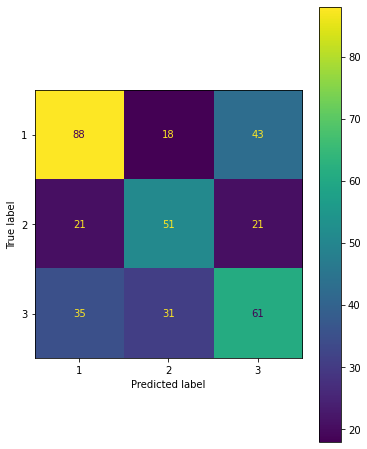

In [15]:
to_dummy = ['edu', 'hus_edu', 'hus_ocu', 'sol']
X_dums, X_train, X_test, y_train, y_test = dummy_transform_scale(X, y, to_dummy, rs = 729)
# set up pipeline
pipe_lr = Pipeline([('lr' , LogisticRegression(random_state=729, max_iter=200))])

params_grid_lr = {#'lr' : [LogisticRegression()],
                  'lr__penalty' : ['l2'],
                  'lr__class_weight' : ['balanced'],
                  'lr__dual' : [True],
                  'lr__solver' : ['liblinear'],
                  'lr__C' : np.logspace(-4, 4, 20),
                  'lr__l1_ratio' : np.logspace(-4, 4, 20)
                 }

lr_clf = GridSearchCV(pipe_lr, param_grid = params_grid_lr, cv = 5, verbose=0, n_jobs=-1)

# fit on data
lr_clf.fit(X_train, y_train)
print(lr_clf.best_params_)
best_lr_nochil_clf = lr_clf.best_estimator_
model_stats(X_dums.columns, best_lr_nochil_clf, 'LogisticRegression', X_test, y_test)

In [16]:
best_lr_nochil_clf_ = best_lr_nochil_clf.named_steps['lr']

In [17]:
coef_df = pd.DataFrame(best_lr_nochil_clf_.coef_, columns = X_dums.columns, index = [1,2,3])

In [18]:
coef_df

,age,chil,rel,work,media,edu_2,edu_3,edu_4,hus_edu_2,hus_edu_3,hus_edu_4,hus_ocu_2,hus_ocu_3,hus_ocu_4,sol_2,sol_3,sol_4
1,1.142667,-1.315524,0.341382,-0.257996,0.604296,-0.451464,-0.890647,-1.590397,-0.489311,-0.419850,-0.291527,0.324119,0.042764,-0.060611,-0.380607,-0.477084,-0.796685
2,-0.028819,0.643209,-0.332189,0.016689,-0.615492,0.751282,1.351555,2.005625,-1.182293,-1.230890,-1.127530,-0.378425,-0.356750,-0.285288,0.074306,0.565200,0.705712
3,-1.230448,0.917853,-0.103881,0.222990,-0.367158,0.114037,0.253523,0.377762,1.538395,1.495932,1.374195,0.013285,0.269876,0.367474,0.379572,0.239234,0.435155


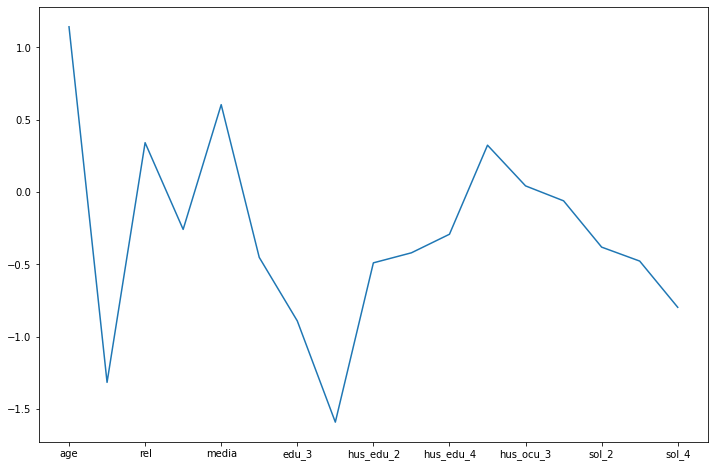

In [19]:
fig, ax = plt.subplots(figsize = [12,8])
coef_df.loc[1].plot()

## LogisticRegression w/ Children capped at 12, dummied

In [20]:
df_chil_cap = X.copy()
df_chil_cap['chil'] = np.where(df_chil_cap.chil > 11, 12, df_chil_cap.chil)
to_dummy = ['edu', 'hus_edu', 'chil', 'hus_ocu', 'sol']
X_dums, X_train, X_test, y_train, y_test = dummy_transform_scale(df_chil_cap, y, to_dummy, rs = 729)

Classifier  LogisticRegression
Num features:  28
Model score:  0.5745257452574526
Accuracy score:  0.5745257452574526
Model F1 (micro):  0.5745257452574526
Model F1 (macro):  0.5660260551248922
Model F1 (weighted):  0.5763221448428955
Cross validation score:  [0.44594595 0.47297297 0.54054054 0.55405405 0.43835616]
Classification Report:
              precision    recall  f1-score   support

           1       0.68      0.63      0.65       149
           2       0.49      0.53      0.51        93
           3       0.53      0.54      0.53       127

    accuracy                           0.57       369
   macro avg       0.57      0.57      0.57       369
weighted avg       0.58      0.57      0.58       369

One-vs-One ROC AUC scores:
0.749358 (macro),
0.751516 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.752777 (macro),
0.753711 (weighted by prevalence)


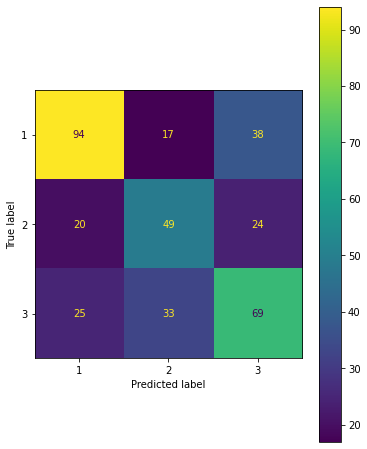

In [21]:
lr_chil_cap_dum = LogisticRegression(random_state=729, max_iter=200,
                                     C = 4.281332398719396,
                                     class_weight = 'balanced',
                                     dual = True,
                                     l1_ratio = 0.0001,
                                     penalty = 'l2',
                                     solver = 'liblinear')
lr_chil_cap_dum.fit(X_train, y_train)
model_stats(X_dums.columns, lr_chil_cap_dum, 'LogisticRegression', X_test, y_test)

## LogisticRegression w/ Children capped at 12, not dummied

In [22]:
to_dummy = ['edu', 'hus_edu', 'hus_ocu', 'sol']
X_dums, X_train, X_test, y_train, y_test = dummy_transform_scale(df_chil_cap, y, to_dummy, rs = 729)

Classifier  LogisticRegression
Num features:  17
Model score:  0.5420054200542005
Accuracy score:  0.5420054200542005
Model F1 (micro):  0.5420054200542005
Model F1 (macro):  0.5377689957700215
Model F1 (weighted):  0.542374234515247
Cross validation score:  [0.47297297 0.44594595 0.45945946 0.45945946 0.52054795]
Classification Report:
              precision    recall  f1-score   support

           1       0.61      0.59      0.60       149
           2       0.51      0.55      0.53        93
           3       0.49      0.48      0.48       127

    accuracy                           0.54       369
   macro avg       0.54      0.54      0.54       369
weighted avg       0.54      0.54      0.54       369

One-vs-One ROC AUC scores:
0.713336 (macro),
0.712374 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.712934 (macro),
0.708726 (weighted by prevalence)


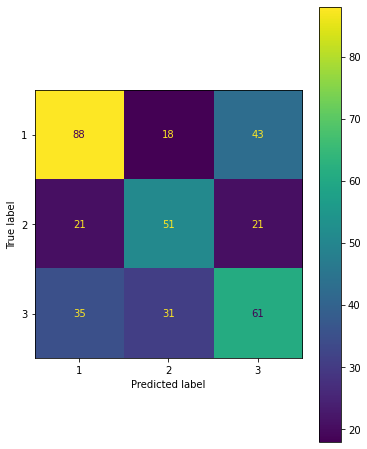

In [23]:
lr_chil_cap_nodum = LogisticRegression(random_state=729, max_iter=200,
                                     C = 4.281332398719396,
                                     class_weight = 'balanced',
                                     dual = True,
                                     l1_ratio = 0.0001,
                                     penalty = 'l2',
                                     solver = 'liblinear')
lr_chil_cap_nodum.fit(X_train, y_train)
model_stats(X_dums.columns, lr_chil_cap_nodum, 'LogisticRegression', X_test, y_test)

## KNN using Pipeline

In [24]:
X = df.copy()
y = X.pop('cmc')

In [25]:
cat_columns = ['edu', 'hus_edu', 'chil', 'hus_ocu', 'sol']
# cat_columns = ['edu', 'hus_edu', 'hus_ocu', 'sol']
for col in cat_columns:
    X[col] = X[col].astype(object)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=729)

In [26]:
# train set
X_train_nums = X_train.select_dtypes('int64')

rs = RobustScaler()
# ss = StandardScaler()

rs.fit(X_train_nums)
nums_df = pd.DataFrame(rs.transform(X_train_nums),
                      index=X_train_nums.index)

X_train_cat = X_train.select_dtypes('object')

ohe = OneHotEncoder(
    drop='first',
    sparse=False)

dums = ohe.fit_transform(X_train_cat)
dums_df = pd.DataFrame(dums,
                       columns=ohe.get_feature_names(),
                       index=X_train_cat.index)

In [27]:
numerical_pipeline = Pipeline(steps=[
    ('rs', RobustScaler())
#     ('ss', StandardScaler())
])
                
categorical_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder( #drop='first',
                         sparse=False,
                         handle_unknown='ignore'))
])

trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, X_train_nums.columns),
    ('categorical', categorical_pipeline, X_train_cat.columns)
])

In [28]:
model_pipe = Pipeline(steps=[
    ('trans', trans),
    ('knn', KNeighborsClassifier())
])

params_grid_knn = {'knn__n_neighbors': [3, 5, 7, 9],
             'knn__p': [1, 2, 3],
             'knn__weights' : ['uniform', 'distance'],
             'knn__metric' : ['euclidean', 'manhattan', 'minkowski']
            }

knn_clf = GridSearchCV(model_pipe, param_grid = params_grid_knn,
                       cv = 3, verbose=0, n_jobs=-1)

{'knn__metric': 'euclidean', 'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'uniform'}
Classifier  KNeighborsClassifier
Num features:  30
Model score:  0.5047489823609227
Accuracy score:  0.5047489823609227
Model F1 (micro):  0.5047489823609227
Model F1 (macro):  0.48531623594072687
Model F1 (weighted):  0.504216029489638
Cross validation score:  [0.44594595 0.50675676 0.45578231 0.46258503 0.46938776]
Classification Report:
              precision    recall  f1-score   support

           1       0.60      0.60      0.60       317
           2       0.43      0.39      0.41       167
           3       0.44      0.46      0.45       253

    accuracy                           0.50       737
   macro avg       0.49      0.48      0.49       737
weighted avg       0.50      0.50      0.50       737

One-vs-One ROC AUC scores:
0.680266 (macro),
0.681718 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.681630 (macro),
0.682940 (weighted by prevalence)


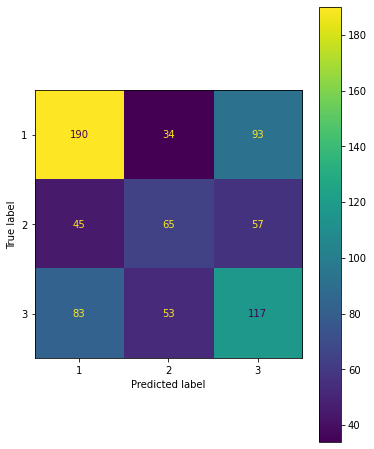

In [29]:
knn_clf.fit(X_train, y_train)
print(knn_clf.best_params_)
best_knn_clf = knn_clf.best_estimator_
model_stats(X_train_df.columns, best_knn_clf, 'KNeighborsClassifier', X_test, y_test)

## SVM

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'pca__n_components': 5, 'svm__class_weight': 'balanced', 'svm__kernel': 'rbf'}
Classifier  SVM
Num features:  30
Model score:  0.4816824966078697
Accuracy score:  0.4816824966078697
Model F1 (micro):  0.4816824966078697
Model F1 (macro):  0.4803294623520013
Model F1 (weighted):  0.48595033962944284
Cross validation score:  [0.50675676 0.51351351 0.49659864 0.50340136 0.52380952]
Classification Report:
              precision    recall  f1-score   support

           1       0.61      0.43      0.51       317
           2       0.35      0.63      0.45       167
           3       0.53      0.45      0.48       253

    accuracy                           0.48       737
   macro avg       0.50      0.50      0.48       737
weighted avg       0.52      0.48      0.49       737

One-vs-One ROC AUC scores:
0.679641 (macro),
0.680223 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.681424 (macro),
0.680301 (weighted by prev

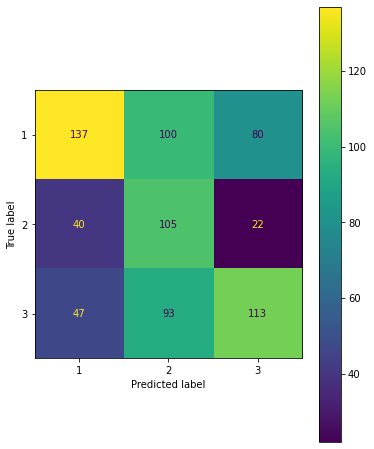

In [30]:
pipe_svm = Pipeline([
                     ('scl', RobustScaler()),
                     ('pca', PCA()),
                     ('svm', SVC(random_state=42, probability=True))])

params_grid_svm = {'svm__class_weight' : ['balanced', 'none'],
                   'svm__kernel' : ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                   'pca__n_components': [0, 2, 5, 10, 15, 20, 30, 45, 64],
                 }

svm_clf = GridSearchCV(pipe_svm, param_grid = params_grid_svm,
                       cv = 5, verbose=1, n_jobs=-1)
svm_clf.fit(X_train, y_train)
print(svm_clf.best_params_)
best_svm_clf = svm_clf.best_estimator_
model_stats(X_train_df.columns, best_svm_clf, 'SVM', X_test, y_test)

In [31]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

# Predicting on new data

In [32]:
columns_1987 = ['v012', 'v106', 'v701', 'v201', 'v130', 'v714', 'v705', 'v109', 'v110', 'v111', 'v312']
columns_2017 = ['v012', 'v106', 'v701', 'v201', 'v130', 'v714', 'v705', 'v157', 'v158', 'v159', 'v312']
cmc_map = {'not using':'1', 'iud':'2', 'pill':'3', 'injections':'3', 'female sterilization':'2', 'condom':'3',
           'periodic abstinence':'3', 'withdrawal':'3', 'jamu jamu (herbs)':'3', 'abstinence':'3', 'norplant':'2',
           'pijat (massage)':'3', 'male sterilization':'2', 'other':'3', 'diaphragm /foam/jelly':'3',
           'injections 3 month':'3', 'injection 1 months':'3', 'implants/norplant':'2', 'other traditional':'3',
           'lactational amenorrhea (lam)':'3', 'other modern method':'3', 'male condom':'3'}
# rel_map = {'muslim':1, 'hindu':0, 'protestant /christian':0, 'catholic':0, 'buddhist':0, 'other':0}
ocu_map = {'agriculture':'4', 'manual':'3', 'sales, services':'2', 'prof, tech, cleric.':'1', 'never worked':'5',
          'other':'5', 'dont know':'5', 'agricultural - self employed':'4', 'industrial worker':'3', 'services':'2',
          'sales':'2', 'professional/technical/managerial':'1', 'clerical':'1', 'did not work':'5', 'don\'t know':'5'}

## Load full 1987 Data

In [33]:
df_1987_ir = pd.read_stata('data/ID_1987_DHS_04012021_1716_161452/IDIR01DT/IDIR01FL.DTA', columns = columns_1987)
df_1987_ir.dropna(subset=['v312'], inplace=True)
# df_1987_ir.dropna(subset=['v130'], inplace=True)
df_1987_ir.drop(columns=['v130'], inplace=True)
df_1987_ir.shape

(11883, 10)

In [34]:
# ['age','edu','hus_edu','chil','rel','work', 'hus_ocu','sol','media','cmc']

In [35]:
df_1987_ir.head()

,v012,v106,v701,v201,v714,v705,v109,v110,v111,v312
0,41,secondary,primary,6,yes,agriculture,no,no,yes,not using
1,27,secondary,secondary,5,no,"prof, tech, cleric.",yes,yes,no,not using
2,43,secondary,secondary,8,no,"sales, services",yes,yes,no,not using
3,41,primary,secondary,9,yes,"prof, tech, cleric.",no,yes,yes,not using
4,29,secondary,secondary,3,no,agriculture,yes,yes,yes,not using


In [36]:
conditions = [(df_1987_ir.v109 == 'yes'), 
              (df_1987_ir.v110 == 'yes'),
              (df_1987_ir.v111 == 'yes')           
]

choices = [1, 1, 1]

df_1987_ir['vmed'] = np.select(conditions, choices, 0)
df_1987_ir.vmed.value_counts()

1    9407
0    2476
Name: vmed, dtype: int64

In [37]:
df_1987_ir.v312 = df_1987_ir.v312.map(cmc_map)
# df_1987_ir.v130 = df_1987_ir.v130.map(rel_map)
df_1987_ir.v312.value_counts()

1    6267
3    3256
2    2360
Name: v312, dtype: int64

In [38]:
df_1987_ir.v705 = df_1987_ir.v705.map(ocu_map)
df_1987_ir.v705.value_counts()

4    4858
3    2943
2    2106
1    1847
5     127
Name: v705, dtype: int64

In [39]:
X_1987 = df_1987_ir.copy()
y_1987 = X_1987.pop('v312')
y_1987 = y_1987.astype(int)
X_1987.v201 = X_1987.v201.astype(object)
X_1987.vmed = X_1987.vmed.astype(object)
X_1987.drop(columns = ['v109','v110','v111'], inplace = True)

In [40]:
X_1987.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11883 entries, 0 to 11883
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   v012    11883 non-null  int8    
 1   v106    11883 non-null  category
 2   v701    11877 non-null  category
 3   v201    11883 non-null  object  
 4   v714    11867 non-null  category
 5   v705    11881 non-null  object  
 6   vmed    11883 non-null  object  
dtypes: category(3), int8(1), object(3)
memory usage: 418.2+ KB


In [41]:
y_1987

0        1
1        1
2        1
3        1
4        1
        ..
11879    3
11880    3
11881    1
11882    1
11883    1
Name: v312, Length: 11883, dtype: int64

## Modeling using best method

{'lr__C': 0.0018329807108324356, 'lr__class_weight': 'balanced', 'lr__dual': True, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Classifier  LogisticRegression
Num features:  39
Model score:  0.5343318747896331
Accuracy score:  0.5343318747896331
Model F1 (micro):  0.5343318747896331
Model F1 (macro):  0.3880791754786202
Model F1 (weighted):  0.4734408828187597
Cross validation score:  [0.54079058 0.52649285 0.54882155 0.55808081 0.53787879]
Classification Report:
              precision    recall  f1-score   support

           1       0.57      0.87      0.69      3076
           2       0.38      0.14      0.20      1185
           3       0.43      0.20      0.28      1681

    accuracy                           0.53      5942
   macro avg       0.46      0.40      0.39      5942
weighted avg       0.49      0.53      0.47      5942

One-vs-One ROC AUC scores:
0.660314 (macro),
0.667177 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.669301 (macro),
0.674251 (weighted by p

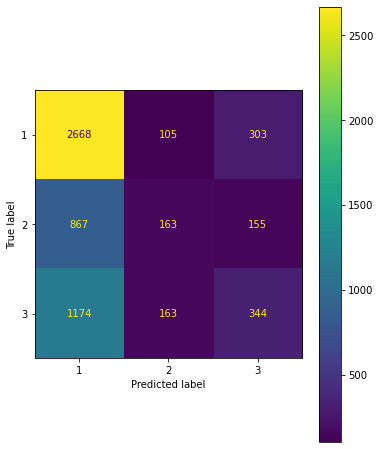

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X_1987, y_1987, test_size=0.5, random_state=729)

# train set
X_train_nums = X_train.select_dtypes('int8')
rs = RobustScaler()
# ss = StandardScaler()
rs.fit(X_train_nums)
nums_df = pd.DataFrame(rs.transform(X_train_nums),
                      index=X_train_nums.index)

X_train_cat = X_train.select_dtypes(['category','object'])
ohe = OneHotEncoder(
    #drop='first',
    handle_unknown='ignore',
    sparse=False)
dums = ohe.fit_transform(X_train_cat)
dums_df = pd.DataFrame(dums,
                       columns=ohe.get_feature_names(),
                       index=X_train_cat.index)

X_train_clean = pd.concat([nums_df,
                 dums_df], axis=1)
# test set
X_test_nums = X_test.select_dtypes('int8')
nums_df = pd.DataFrame(rs.transform(X_test_nums),
                      index=X_test_nums.index)

X_test_cat = X_test.select_dtypes(['category','object'])
dums_df = pd.DataFrame(ohe.transform(X_test_cat),
                       columns=ohe.get_feature_names(),
                       index=X_test_cat.index)
X_test_clean = pd.concat([nums_df,
                 dums_df], axis=1)

new_pipe_lr = Pipeline([('lr', LogisticRegression(random_state=1, max_iter=200))])

params_grid_new_lr = {'lr__penalty' : ['l2'],
                  'lr__class_weight' : ['balanced'],
                  'lr__dual' : [True],
                  'lr__solver' : ['liblinear'],
                  'lr__C' : np.logspace(-4, 4, 20),
                  #'lr__l1_ratio' : np.logspace(-4, 4, 20) # only needed for elasticnet
                     }

new_lr_clf = GridSearchCV(new_pipe_lr, param_grid = params_grid_new_lr,
                       cv = 3, verbose=0, n_jobs=-1)

new_lr_clf.fit(X_train_clean, y_train)
print(new_lr_clf.best_params_)
best_new_lr_clf = new_lr_clf.best_estimator_
model_stats(X_train_clean.columns, best_new_lr_clf, 'LogisticRegression', X_test_clean, y_test)

In [43]:
y_test

7573     3
2962     2
8825     1
6303     3
5376     1
        ..
6479     3
6174     1
2604     1
11554    3
5578     2
Name: v312, Length: 5942, dtype: int64

## Comparing against 2017 data as holdout set

In [44]:
df_2017_ir = pd.read_stata('data/ID_2017_DHS_04012021_1713_161452/IDIR71DT/IDIR71FL.DTA', columns = columns_2017)
df_2017_ir.drop(columns=['v130'], inplace=True)
df_2017_ir.dropna(subset=['v701','v714','v705', 'v157', 'v158', 'v159'], inplace=True)
# df_1987_ir.dropna(subset=['v130'], inplace=True)
df_2017_ir.shape

(34245, 10)

In [45]:
df_2017_ir.isna().sum()

v012    0
v106    0
v701    0
v201    0
v714    0
v705    0
v157    0
v158    0
v159    0
v312    0
dtype: int64

In [46]:
df_2017_ir.v157.value_counts()

not at all               20174
less than once a week    10786
at least once a week      3285
Name: v157, dtype: int64

In [47]:
conditions = [df_2017_ir.v157 != 'not at all',
              df_2017_ir.v158 != 'not at all',
              df_2017_ir.v159 != 'not at all']
choices = [1, 1, 1]

df_2017_ir['vmed'] = np.select(conditions, choices, 0)
df_2017_ir.vmed.value_counts()

1    33046
0     1199
Name: vmed, dtype: int64

In [48]:
df_2017_ir.v312 = df_2017_ir.v312.map(cmc_map)
df_2017_ir.v312.value_counts()

3    16328
1    13464
2     4453
Name: v312, dtype: int64

In [49]:
df_2017_ir.v705 = df_2017_ir.v705.map(ocu_map)
df_2017_ir.v705.value_counts()

2    10150
4     9378
3     8454
1     5419
5      844
Name: v705, dtype: int64

In [50]:
X_2017 = df_2017_ir.copy()
y_2017 = X_2017.pop('v312')
y_2017 = y_2017.astype(int)
X_2017.v201 = X_2017.v201.astype(object)
X_2017.vmed = X_2017.vmed.astype(object)
X_2017.drop(columns = ['v157','v158','v159'], inplace = True)

In [51]:
X_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34245 entries, 0 to 49626
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   v012    34245 non-null  int8    
 1   v106    34245 non-null  category
 2   v701    34245 non-null  category
 3   v201    34245 non-null  object  
 4   v714    34245 non-null  category
 5   v705    34245 non-null  object  
 6   vmed    34245 non-null  object  
dtypes: category(3), int8(1), object(3)
memory usage: 1.2+ MB


In [52]:
X_2017_nums = X_2017.select_dtypes('int8')
nums_df = pd.DataFrame(rs.transform(X_2017_nums),
                      index=X_2017_nums.index)

X_2017_cat = X_2017.select_dtypes(['category','object'])
dums_df = pd.DataFrame(ohe.transform(X_2017_cat),
                       columns=ohe.get_feature_names(),
                       index=X_2017_cat.index)
X_2017_clean = pd.concat([nums_df,
                 dums_df], axis=1)

Classifier  LogisticRegression
Num features:  39
Model score:  0.4172579938677179
Accuracy score:  0.4172579938677179
Model F1 (micro):  0.4172579938677179
Model F1 (macro):  0.3567202528926967
Model F1 (weighted):  0.37826718115953567
Cross validation score:  [0.57234633 0.57658052 0.5847569  0.57001022 0.53847277]
Classification Report:
              precision    recall  f1-score   support

           1       0.46      0.75      0.57     13464
           2       0.19      0.33      0.24      4453
           3       0.61      0.16      0.26     16328

    accuracy                           0.42     34245
   macro avg       0.42      0.42      0.36     34245
weighted avg       0.50      0.42      0.38     34245

One-vs-One ROC AUC scores:
0.619538 (macro),
0.619507 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.620461 (macro),
0.622680 (weighted by prevalence)


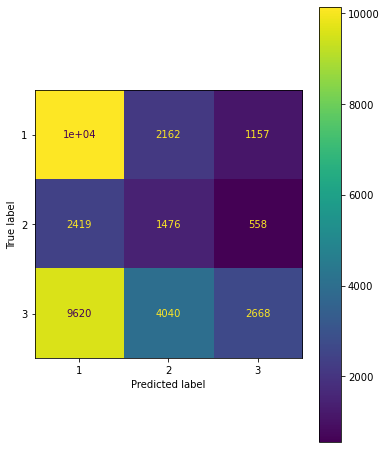

In [53]:
y_2017_pred = best_new_lr_clf.predict(X_2017_clean)
model_stats(X_2017_clean.columns, best_new_lr_clf, 'LogisticRegression', X_2017_clean, y_2017)